# Lab | Classification, Handling Imbalanced Data

<b>TASK:</b> Identify customers that are more likely to default/churn and thus prevent losses from such customers.<br>
Using historical customer data from an internet service provider 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
churnData = pd.read_csv("DATA_Customer-Churn.csv")
churnData.head()

# churn: Yes/No = target variable

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


### Preprocessing

In [3]:
churnData.rename(columns=lambda name:name.lower().replace(' ','_'), inplace=True)

In [4]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   onlinesecurity    7043 non-null   object 
 7   onlinebackup      7043 non-null   object 
 8   deviceprotection  7043 non-null   object 
 9   techsupport       7043 non-null   object 
 10  streamingtv       7043 non-null   object 
 11  streamingmovies   7043 non-null   object 
 12  contract          7043 non-null   object 
 13  monthlycharges    7043 non-null   float64
 14  totalcharges      7043 non-null   object 
 15  churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [5]:
churnData.seniorcitizen.value_counts()
# seniorcitizen already dummy encoded (assume 1 as senior?)

seniorcitizen
0    5901
1    1142
Name: count, dtype: int64

In [6]:
churnData.contract.value_counts()

contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

In [7]:
# convert totalcharges column to numeric column
churnData.totalcharges = pd.to_numeric(churnData.totalcharges, errors='coerce')

In [9]:
# fill nas with mean
churnData.totalcharges = churnData.totalcharges.fillna(churnData.totalcharges.mean())

In [10]:
# check for duplicates and drop
churnData.duplicated().any()
churnData.drop_duplicates(inplace=True)

In [11]:
# encode the target variable
churn_encoder = OrdinalEncoder(categories=[['No','Yes']])
churnData['churn'] = churn_encoder.fit_transform(churnData[['churn']])

<b>Splitting and balancing the data

In [14]:
X = churnData[['tenure','seniorcitizen','monthlycharges','totalcharges']]
y = churnData[['churn']]

In [15]:
# train test split
TT_SPLIT = 0.2     
RAND_STATE = 99  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_SPLIT,random_state=RAND_STATE) 

In [16]:
y_train.value_counts()

churn
0.0      4116
1.0      1479
Name: count, dtype: int64

In [17]:
# balancing: upsampling minority data using SMOTE **after** train test split

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

churn
0.0      4116
1.0      4116
Name: count, dtype: int64

In [18]:
# transform the data using PowerTransformer because no gaussian distribution

pt = PowerTransformer()
pt.fit(X_train)

X_train = pt.transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns

X_test = pt.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = X.columns

In [19]:
def evaluate_classification_model(y_train, y_pred_train, y_test, y_pred_test):
    """
    Generates performance metrics and comparisons of labels with their predicted values
    :param y_train: training labels
    :param y_pred_train: predictions from the model on the training set
    :param y_test: test labels
    :param y_pred_test: predictions from the model on the test set
    :returns: 3 dfs - Accuracy, Precision, and Recall scores, y_train vs. y_pred_train and y_test vs. y_pred_dist
    """
    performance_df = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train),
                                         precision_score(y_train, y_pred_train),
                                         recall_score(y_train, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})
    
    pd.options.display.float_format = '{:.2f}'.format

    df_train = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train})
    df_test  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test})

    return performance_df, df_train, df_test



### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [21]:
log_model = LogisticRegression() 

log_model.fit(X_train, y_train)

y_pred_train_log = log_model.predict(X_train)
y_pred_test_log = log_model.predict(X_test)

performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_log),
                                         precision_score(y_train, y_pred_train_log),
                                         recall_score(y_train, y_pred_train_log)],
                               'Test': [accuracy_score(y_test, y_pred_test_log),
                                        precision_score(y_test, y_pred_test_log),
                                        recall_score(y_test, y_pred_test_log)]})

display(performance_log)


,Error_metric,Train,Test
0,Accuracy,0.731778,0.742673
1,Precision,0.732004,0.510476
2,Recall,0.731293,0.722372


In [ ]:
# noticing a very low precision score

In [22]:
recall_scores_log = cross_val_score(log_model, X_train, y_train, cv=5, scoring="recall")
recall_scores_log.mean()

0.726920513395227

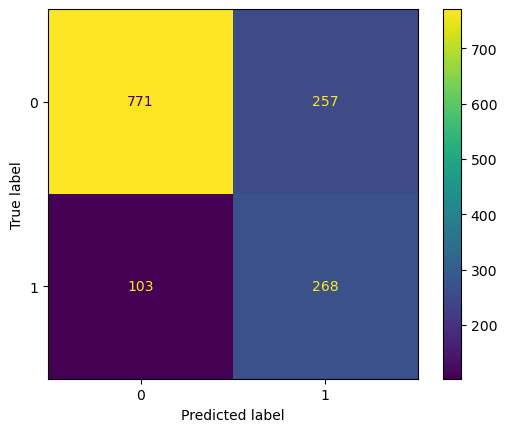

In [23]:
# confusion matrix for log_model

cm_log = confusion_matrix(y_test, y_pred_test_log, labels = log_model.classes_)
disp = ConfusionMatrixDisplay(cm_log)
disp.plot()

### KNN Classification

In [74]:
knn_model = KNeighborsClassifier(n_neighbors=5,weights='uniform')
knn_model.fit(X_train, y_train) 
y_pred_knn = knn_model.predict(X_test.values) 
y_pred_train_knn = knn_model.predict(X_train.values)

KNeighborsClassifier()

In [85]:
# hyperparametre tuning
param_grid = {"n_neighbors" : [3,5,7,8,10,15]}

grid_search = GridSearchCV(knn_model, param_grid, scoring='recall', cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train,y_train.values.ravel())


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 8, 10, 15]},
             return_train_score=True, scoring='recall')

In [86]:
best_params = grid_search.best_params_
best_params

{'n_neighbors': 15}

In [90]:
# retraining the model with best n_neighbor = 15

knn_model = KNeighborsClassifier(n_neighbors=15,weights='uniform')
knn_model.fit(X_train, y_train) 
y_pred_knn = knn_model.predict(X_test.values) 
y_pred_train_knn = knn_model.predict(X_train.values)

KNeighborsClassifier(n_neighbors=15)

In [91]:
performance_knn = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_knn),
                                         precision_score(y_train, y_pred_train_knn),
                                         recall_score(y_train, y_pred_train_knn)],
                               'Test': [accuracy_score(y_test, y_pred_knn),
                                        precision_score(y_test, y_pred_knn),
                                        recall_score(y_test, y_pred_knn)]})

display(performance_log)

,Error_metric,Train,Test
0,Accuracy,0.830053,0.703360
1,Precision,0.807006,0.460145
2,Recall,0.867590,0.684636


In [92]:
recall_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=5, scoring="recall")
print(f"Recall scores of knn_model: {recall_scores_knn}")
print(f" with standard devation of {np.std(recall_scores_knn)}")

Recall scores of knn_model: [0.7691373  0.75728155 0.81652491 0.78614824 0.81530984]
 with standard devation of 0.02391014842722334


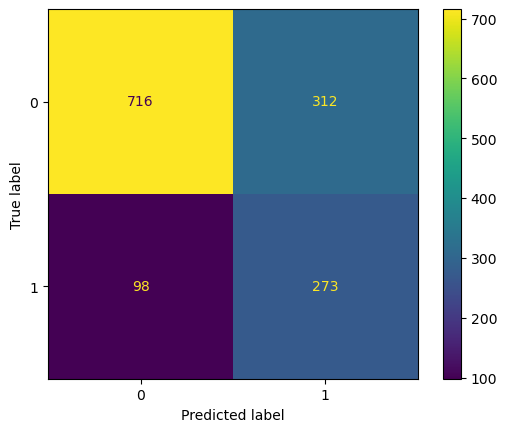

In [93]:
# confusion matrix for knn_model

cm_knn = confusion_matrix(y_test, y_pred_knn, labels = knn_model.classes_)
disp = ConfusionMatrixDisplay(cm_knn)
disp.plot()

### Decision Tree Classifier

In [94]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [81]:
dt_model = DecisionTreeClassifier(max_depth=3)
dt_model.fit(X_train, y_train)
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

DecisionTreeClassifier(max_depth=3)

In [95]:
# hyperparametre tuning
param_grid = {"max_depth" : [1,2,3,4,5,6,7]}

grid_search = GridSearchCV(dt_model, param_grid, scoring='recall',cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train,y_train.values.ravel())

best_params = grid_search.best_params_
best_params

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7]},
             return_train_score=True, scoring='recall')

{'max_depth': 3}

In [96]:
# retrain decision tree classifier with max_depth = 3
dt_model = DecisionTreeClassifier(max_depth=3)
dt_model.fit(X_train, y_train)
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

DecisionTreeClassifier(max_depth=3)

In [97]:
performance_dt = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt),
                                         recall_score(y_train, y_pred_train_dt)],
                               'Test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt),
                                        recall_score(y_test, y_pred_test_dt)]})

display(performance_df)

,Error_metric,Train,Test
0,Accuracy,0.739796,0.673338
1,Precision,0.692248,0.439093
2,Recall,0.863460,0.835580


In [100]:
recall_scores_dt = cross_val_score(dt_model, X_train, y_train, cv=5, scoring="recall")
print(f"Recall scores of dt_model: {recall_scores_dt}")
print(f" with standard devation of {np.std(recall_scores_dt)}")

Recall scores of dt_model: [0.84204131 0.84830097 0.86634265 0.86512758 0.86391252]
 with standard devation of 0.010004557520810302


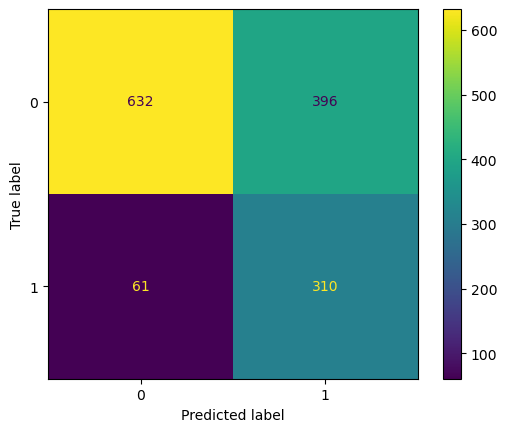

In [101]:
cm_dt = confusion_matrix(y_test, y_pred_test_dt, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(cm_dt)
disp.plot()

<Figure size 400x100 with 0 Axes>

<BarContainer object of 4 artists>

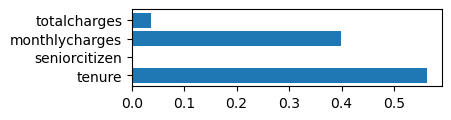

In [102]:
# examine feature importance
plt.figure(figsize=(4,1))
plt.barh(X.columns,dt_model.feature_importances_)

[Text(0.5, 0.875, 'tenure <= -0.084\ngini = 0.5\nsamples = 8232\nvalue = [4116, 4116]'),
 Text(0.25, 0.625, 'monthlycharges <= -1.601\ngini = 0.422\nsamples = 3763\nvalue = [1139, 2624]'),
 Text(0.125, 0.375, 'totalcharges <= -1.897\ngini = 0.417\nsamples = 502\nvalue = [353, 149]'),
 Text(0.0625, 0.125, 'gini = 0.467\nsamples = 143\nvalue = [53, 90]'),
 Text(0.1875, 0.125, 'gini = 0.275\nsamples = 359\nvalue = [300, 59]'),
 Text(0.375, 0.375, 'monthlycharges <= 0.037\ngini = 0.366\nsamples = 3261\nvalue = [786, 2475]'),
 Text(0.3125, 0.125, 'gini = 0.454\nsamples = 1456\nvalue = [507, 949]'),
 Text(0.4375, 0.125, 'gini = 0.261\nsamples = 1805\nvalue = [279, 1526]'),
 Text(0.75, 0.625, 'monthlycharges <= 0.001\ngini = 0.445\nsamples = 4469\nvalue = [2977, 1492]'),
 Text(0.625, 0.375, 'monthlycharges <= -1.451\ngini = 0.233\nsamples = 1640\nvalue = [1419, 221]'),
 Text(0.5625, 0.125, 'gini = 0.072\nsamples = 748\nvalue = [720, 28]'),
 Text(0.6875, 0.125, 'gini = 0.339\nsamples = 892\nva

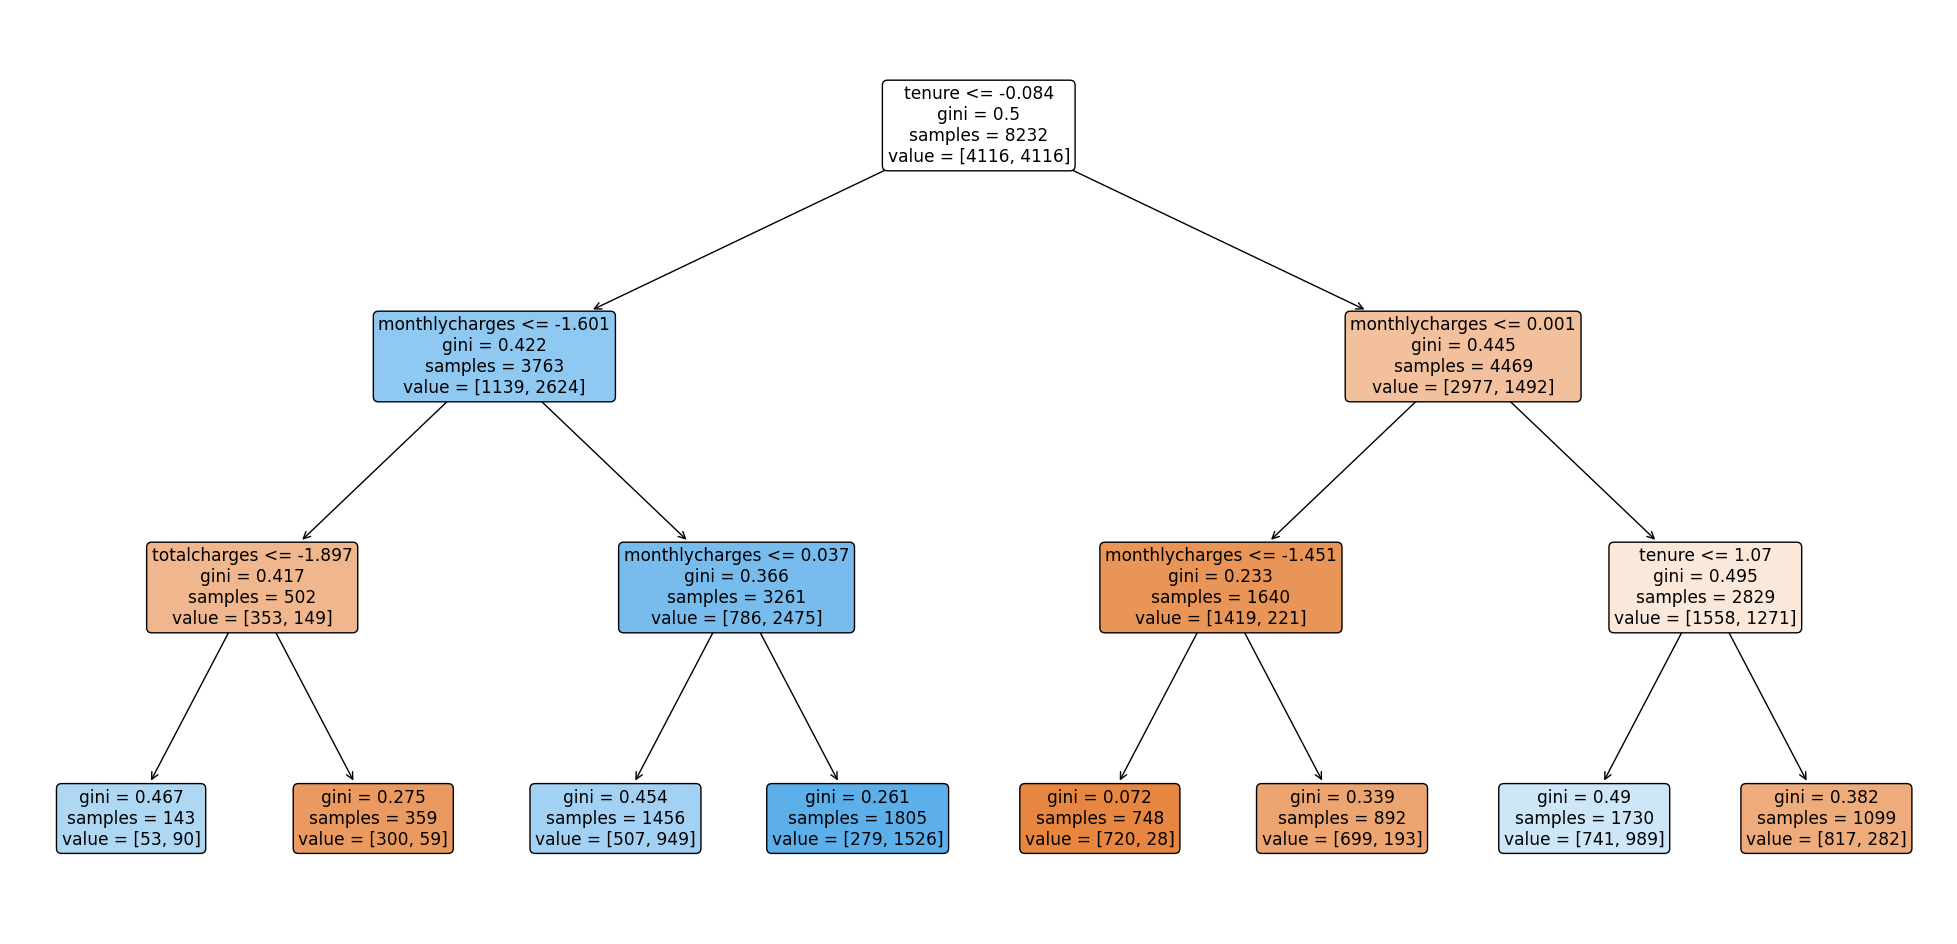

In [106]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (25,12))

plot_tree(dt_model,filled = True, rounded=True,feature_names=list(X.columns))
plt.show() 

### Random Forest Model

In [107]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestClassifier
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None) 

In [108]:
rfc_ops = {"max_depth":4,
           "min_samples_leaf":20, 
           "n_estimators":100, 
           "bootstrap":True, 
           "oob_score":True, 
           "random_state":RAND_STATE}

rfc_model = RandomForestClassifier(**rfc_ops)

rfc_model.fit(X_train, y_train)

y_pred_train_rfc = rfc_model.predict(X_train)
y_pred_test_rfc = rfc_model.predict(X_test)

RandomForestClassifier(max_depth=4, min_samples_leaf=20, oob_score=True,
                       random_state=99)

In [110]:
# hyperparametre tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth':[3,4]
    }

grid_search = GridSearchCV(rfc_model, param_grid, scoring='recall', cv=5, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train,y_train.values.ravel())

best_params = grid_search.best_params_
best_params

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=4, min_samples_leaf=20,
                                              oob_score=True, random_state=99),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4], 'n_estimators': [50, 100]},
             return_train_score=True, scoring='recall')

{'max_depth': 4, 'n_estimators': 100}

In [111]:
# retrain random forest classifier with max_depth = 4, n_estimators = 100

rfc_ops = {"max_depth":4,
           "min_samples_leaf":20, 
           "n_estimators":100, 
           "bootstrap":True, 
           "oob_score":True, 
           "random_state":RAND_STATE}

rfc_model = RandomForestClassifier(**rfc_ops)

rfc_model.fit(X_train, y_train)

y_pred_train_rfc = rfc_model.predict(X_train)
y_pred_test_rfc = rfc_model.predict(X_test)

RandomForestClassifier(max_depth=4, min_samples_leaf=20, oob_score=True,
                       random_state=99)

In [112]:
performance_rfc = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_rfc),
                                         precision_score(y_train, y_pred_train_rfc),
                                         recall_score(y_train, y_pred_train_rfc)],
                               'Test': [accuracy_score(y_test, y_pred_test_rfc),
                                        precision_score(y_test, y_pred_test_rfc),
                                        recall_score(y_test, y_pred_test_rfc)]})
performance_rfc

,Error_metric,Train,Test
0,Accuracy,0.750972,0.714081
1,Precision,0.728945,0.475465
2,Recall,0.799077,0.757412


### Summary
Performance of all four models: Logistic, KNN, DecisionTreeClassifier, RandomForest

In [146]:
performance_recall_compared = pd.concat([performance_log.iloc[2],performance_knn.iloc[2],performance_dt.iloc[2],performance_rfc.iloc[2]],axis=1,ignore_index=True)
performance_recall_compared.columns = ['logistic','knn','dtclassifier','randomforest']
performance_recall_compared.drop('Error_metric',axis=0,inplace=True)
performance_recall_compared[['logistic', 'knn', 'dtclassifier', 'randomforest']] = performance_recall_compared[['logistic', 'knn', 'dtclassifier', 'randomforest']].apply(lambda x: x.astype(float)).round(2)
performance_recall_compared

,logistic,knn,dtclassifier,randomforest
Train,0.87,0.83,0.86,0.80
Test,0.68,0.74,0.84,0.76


<b>K-Fold Cross Validation</b>

In [153]:
model_pipeline = [log_model, knn_model, dt_model, rfc_model]
model_names = ["Logistic Regression", "KNN", "Classification Tree","Random Forest"]
mean_recall_scores = {}

i = 0
for model in model_pipeline:
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='recall'))
    mean_recall_scores[model_names[i]] = mean_score
    i = i+1
    
print("Comparing the 3 regression recall scores we find \n")

kfold_recall = pd.DataFrame([mean_recall_scores], index=["mean_recall_score"]).round(2)
kfold_recall.columns = performance_recall_compared.columns
kfold_recall

Comparing the 3 regression recall scores we find 



,logistic,knn,dtclassifier,randomforest
mean_recall_score,0.73,0.79,0.86,0.78


In [154]:
performance_recall_compared.loc["mean_recall_score"] = kfold_recall.loc["mean_recall_score"]

In [155]:
performance_recall_compared

,logistic,knn,dtclassifier,randomforest
Train,0.87,0.83,0.86,0.80
Test,0.68,0.74,0.84,0.76
mean_recall_score,0.73,0.79,0.86,0.78


### finding a strong max_depth

Create a <b>function</b>: train and test DT classifier over max_depth = list of integers

In [52]:
# list of integers
depths = list(range(1,10))
depths

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [35]:
# cheating because we are overfitting to the test set
# need cross-validation (e.g. GridSearch), see below

def train_test_decision_tree(X_train, X_test, y_train, y_test, depths):

    # Empty list to store each model's performance scores
    performance_scores = []

    # Iterate through each max_depth value and train/test the model
    for depth in depths:
        # Create the Decision Tree Classifier with the current max_depth
        dtc_model = DecisionTreeClassifier(max_depth=depth, random_state=42)

        # Train the model
        dtc_model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = dtc_model.predict(X_test)

        # Calculate the accuracy and store it
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        performance_scores.append([depth, accuracy, precision, recall])
    
    performance_scores = pd.DataFrame(performance_scores, columns=['max_depth', 'accuracy', 'precision', 'recall'])

    #Return the results dictionary
    return performance_scores

In [36]:
performance_scores = train_test_decision_tree(X_train, X_test, y_train, y_test, depths)

In [37]:
performance_scores

,max_depth,accuracy,precision,recall
0,1,0.70,0.45,0.62
1,2,0.74,0.50,0.57
2,3,0.68,0.45,0.82
3,4,0.72,0.48,0.77
4,5,0.72,0.48,0.76
5,6,0.69,0.45,0.76
6,7,0.71,0.47,0.75
7,8,0.69,0.45,0.75
8,9,0.71,0.46,0.72
